1) Import Libraries + Load RFM Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set(style="whitegrid")

# Load RFM results
file_path = "../data/processed/rfm_results.csv"
rfm = pd.read_csv(file_path)

rfm.head()


,Customer ID,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
0,12346.0,529,11,372.86,1,4,2,142,Others
1,12347.0,2,8,5633.32,4,4,4,444,Champions
2,12348.0,75,5,2019.40,3,3,3,333,Loyal Customers
3,12349.0,19,4,4428.69,4,3,4,434,Loyal Customers
4,12350.0,310,1,334.40,2,1,1,211,At Risk


2) เลือกเฉพาะคอลัมน์ RFM สำหรับการทำ K-Means
    ไม่ใช้ RFM_Score เพราะเป็นตัวเลขที่เกิดจากการจัดระดับ ไม่ได้สะท้อนระยะห่างจริง

In [2]:
rfm_kmeans = rfm[["Recency", "Frequency", "Monetary"]]
rfm_kmeans.head()


,Recency,Frequency,Monetary
0,529,11,372.86
1,2,8,5633.32
2,75,5,2019.40
3,19,4,4428.69
4,310,1,334.40


3) Standardization (สำคัญมากสำหรับ K-Means)

In [3]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_kmeans)

rfm_scaled[:5]


array([[ 1.56565779,  0.36208089, -0.17842186],
       [-0.95242241,  0.13147553,  0.18375438],
       [-0.60361813, -0.09912983, -0.06505959],
       [-0.87119401, -0.17599828,  0.10081708],
       [ 0.51924496, -0.40660364, -0.18106978]])

4) หาจำนวน Cluster ที่เหมาะสมด้วย Elbow Method

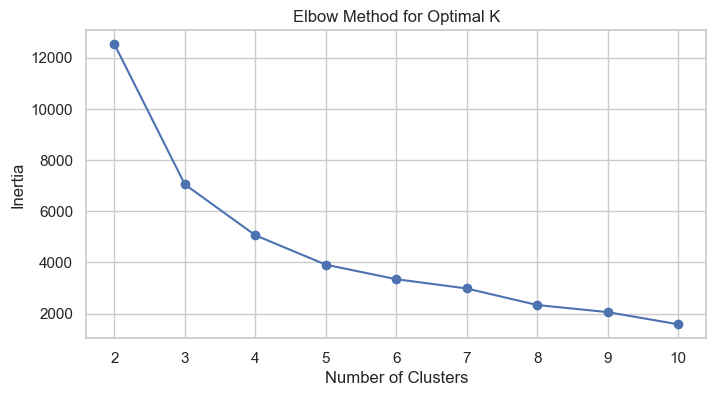

In [4]:
inertia = []

K_range = range(2, 11)  # ลอง 2–10 คลัสเตอร์

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    inertia.append(model.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()


5) ตรวจ Silhouette Score เพื่อความมั่นใจ

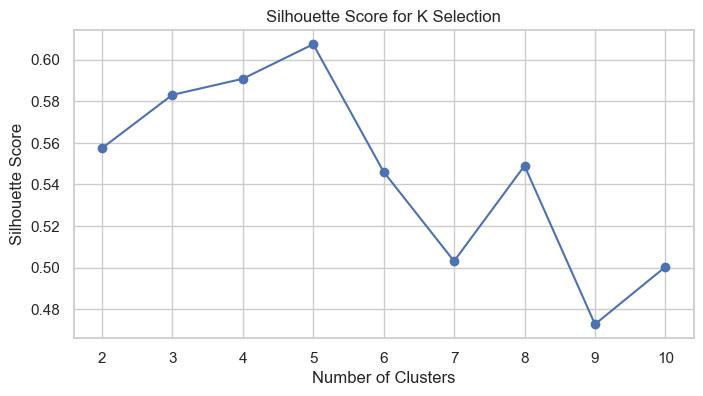

[0.5573890682495446,
 0.5831477576124571,
 0.5909125077158712,
 0.6075470981128634,
 0.5460980062078413,
 0.5030651276445091,
 0.5490242042021626,
 0.47266274504735806,
 0.5003294165083166]

In [5]:
silhouette_scores = []

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,4))
plt.plot(K_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for K Selection")
plt.show()

silhouette_scores


6) ทำ K-Means ด้วยจำนวนคลัสเตอร์ที่เลือก (สมมติ k=4)

In [6]:
k = 4  # ปรับตามที่ได้จาก Elbow + Silhouette

kmeans = KMeans(n_clusters=k, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,Customer ID,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment,Cluster
0,12346.0,529,11,372.86,1,4,2,142,Others,0
1,12347.0,2,8,5633.32,4,4,4,444,Champions,1
2,12348.0,75,5,2019.40,3,3,3,333,Loyal Customers,1
3,12349.0,19,4,4428.69,4,3,4,434,Loyal Customers,1
4,12350.0,310,1,334.40,2,1,1,211,At Risk,0


7) ดูจำนวนลูกค้าแต่ละกลุ่ม

In [7]:
rfm["Cluster"].value_counts().sort_index()


Cluster
0    2001
1    3838
2      34
3       4
Name: count, dtype: int64

8) ค่าเฉลี่ยของแต่ละ Cluster (ตีความ)

In [8]:
cluster_summary = rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean()
cluster_summary


,Recency,Frequency,Monetary
Cluster,,,
0,462.678161,2.218391,755.883835
1,66.824127,7.307712,2976.070418
2,26.676471,106.705882,80574.714471
3,3.500000,212.500000,436835.792500


9) Visualize — Heatmap ของค่าเฉลี่ยในแต่ละคลัสเตอร์

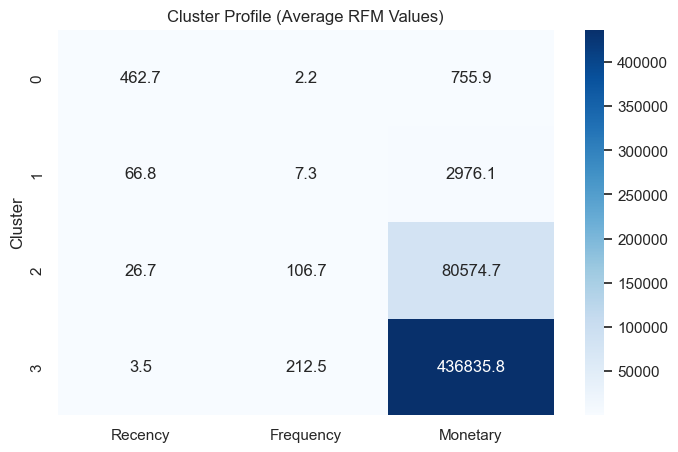

In [9]:
plt.figure(figsize=(8,5))
sns.heatmap(cluster_summary, annot=True, cmap="Blues", fmt=".1f")
plt.title("Cluster Profile (Average RFM Values)")
plt.show()


10) Scatter Plot (2D PCA) เพื่อดูการกระจายคลัสเตอร์

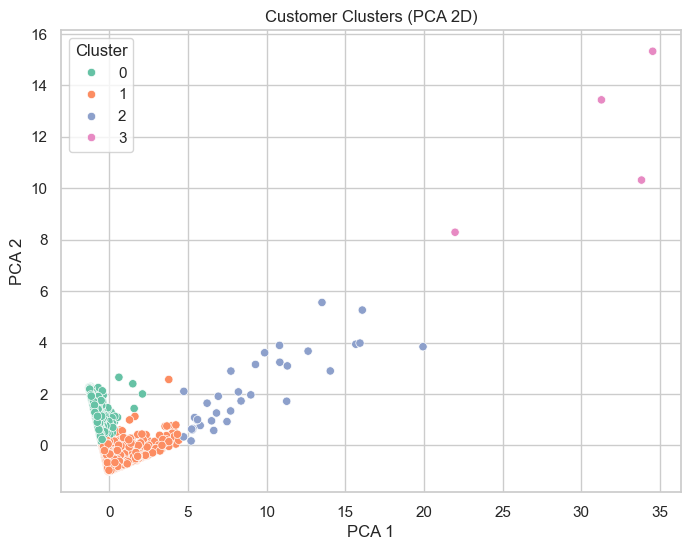

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=components[:,0], 
    y=components[:,1], 
    hue=rfm["Cluster"], 
    palette="Set2"
)
plt.title("Customer Clusters (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


11) Export ไฟล์สำหรับใช้งานต่อ

In [11]:
output_path = "../data/processed/rfm_kmeans_clusters.csv"
rfm.to_csv(output_path, index=False)

output_path


'../data/processed/rfm_kmeans_clusters.csv'

12) Insight อัตโนมัติ

In [12]:
for c in sorted(rfm["Cluster"].unique()):
    print(f"\n======= Cluster {c} =======")
    df_c = rfm[rfm["Cluster"] == c]
    print("จำนวนลูกค้า:", len(df_c))
    print("Recency เฉลี่ย:", round(df_c["Recency"].mean(), 1))
    print("Frequency เฉลี่ย:", round(df_c["Frequency"].mean(), 1))
    print("Monetary เฉลี่ย:", round(df_c["Monetary"].mean(), 1))



======= Cluster 0 =======
จำนวนลูกค้า: 2001
Recency เฉลี่ย: 462.7
Frequency เฉลี่ย: 2.2
Monetary เฉลี่ย: 755.9

======= Cluster 1 =======
จำนวนลูกค้า: 3838
Recency เฉลี่ย: 66.8
Frequency เฉลี่ย: 7.3
Monetary เฉลี่ย: 2976.1

======= Cluster 2 =======
จำนวนลูกค้า: 34
Recency เฉลี่ย: 26.7
Frequency เฉลี่ย: 106.7
Monetary เฉลี่ย: 80574.7

======= Cluster 3 =======
จำนวนลูกค้า: 4
Recency เฉลี่ย: 3.5
Frequency เฉลี่ย: 212.5
Monetary เฉลี่ย: 436835.8
